In this task, I will train an autoencoder to detect anomalies on the Munch and Vincent datasets. Each paint has been labeled either 0 (corresponding to abnormal painting -- Vincent), or 1 (corresponding to normal painting -- Munch). I am interested in identifying the abnormal painting.


Note: This is a labeled dataset, so we could phrase this as a supervised learning problem. Recall that an autoencoder is trained to minimize reconstruction error. I will train an autoencoder on the normal paintings only, then use it to reconstruct all the data. Our hypothesis is that the abnormal paintings will have higher reconstruction error. I will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import os
# import tqdm

1. Dataset

In [6]:
############## Read Munch data and split it ###################
# painting_details_munch =  pd.read_csv('./datasets/munch_paintings/edvard_munch.csv')
# painting_details.head()
image_path_munch = './datasets/munch_paintings/munch_paintings'
# ImageFolder expects the class folder
images_dataset_munch = torchvision.datasets.ImageFolder(image_path_munch,\
                                                  transform=transforms.Compose([transforms.Resize(256), 
                                                    #smaller edge of the image will be matched to this number.
                                 transforms.CenterCrop(256),
                                 transforms.ToTensor()]))
images_dataset_munch.samples = [(d, 1) if s >= 0 else (d, s) for d, s in images_dataset_munch.samples] 
# here after viewing real size for images we can say 256*256 would be good.
# image_size = (256,256)
# separate data into training and testing (testing will also be validation during training)
test_split = .2
# val_split = .1
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and testing splits:
data_size = len(images_dataset_munch)
indices = list(range(data_size))
split = int(np.floor(test_split * data_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 32

# wrapup into dataloader
train_loader = DataLoader(images_dataset_munch, batch_size=batch_size,sampler=train_sampler)
test_loader_munch = DataLoader(images_dataset_munch, batch_size=batch_size,sampler=test_sampler,shuffle=False)

################ Read Vincent data and random sample ##################
munchtest_num = len(test_indices)
image_path_vincent = './datasets/vincent_paintings/VincentVanGogh'
images_dataset_vincent = torchvision.datasets.ImageFolder(image_path_vincent,\
                                                  transform=transforms.Compose([transforms.Resize(256), 
                                                    #smaller edge of the image will be matched to this number.
                                 transforms.CenterCrop(256),
                                 transforms.ToTensor()]))

images_dataset_vincent.samples = [(d, 0) if s >= 0 else (d, s) for d, s in images_dataset_vincent.samples] # set all vincent paintings label to 0


############## Prepare test dataloader, which is Munch:Vincent = 1:1, Munch label =1, Vincent label = 0
indices_vincent = list(range(len(images_dataset_vincent)))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices_vincent)
vincent_downsampled = indices_vincent[:munchtest_num]
vincent_sampler = SubsetRandomSampler(vincent_downsampled)
test_loader_vincent = DataLoader(images_dataset_vincent, batch_size=batch_size,sampler=vincent_sampler,shuffle=False)

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0)) # (3,256,256) -> (256,256,3)

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1) #Given an interval, values outside the interval are clipped to the interval edges.

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Show training data (Munch)

<AxesSubplot:>

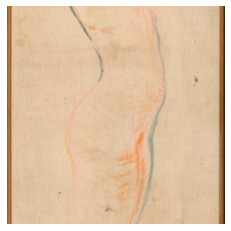

In [7]:
images, labels = next(iter(train_loader))
imshow(images[10], normalize=False)

Show test data (Munch)

<AxesSubplot:>

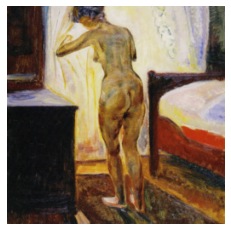

In [8]:
images, labels = next(iter(test_loader_munch))
imshow(images[10], normalize=False)

Show test data (Vincent)

<AxesSubplot:>

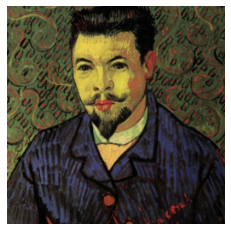

In [9]:
images, labels = next(iter(test_loader_vincent))
imshow(images[10], normalize=False)

2. Model

In [10]:
# latent_dim = 64

class AnomalyDetector_AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # self.latent_dim = latent_dim
        # encoder (1 layer); Input=3*256*256
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
            )
        # decoder (1 layer)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1)
            )

    def forward(self, input_features):
        encoded = self.encoder(input_features)
        decoded = self.decoder(encoded)
        return decoded
    
# load model to the specified device, either gpu or cpu
anomaly_detector = AnomalyDetector_AE().to(device)
anomaly_detector_optmizer = torch.optim.Adam(anomaly_detector.parameters(), lr=1e-3)
anomaly_detector_criterion = nn.MSELoss()

# Train model
def itr_merge(*itrs):
    for itr in itrs:
        for _, v in enumerate(itr):
            yield v

def train_detector(num_epochs,model,optimizer,criterion,train_loader,valid_loader):
    # for epoch in tqdm(range(epochs)):
    for epoch in range(num_epochs):
        loss_tr = 0
        loss_val = 0
        # training loop
        for _, data in enumerate(train_loader):
            batch_features = data[0]
            # print("######",batch_features.shape)
            # load it to active device
            batch_features = batch_features.to(device)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            # compute reconstructions
            outputs = model(batch_features)
            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)
            # compute accumulated gradients
            train_loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()
            # add the mini-batch training loss to epoch loss
            loss_tr += train_loss.item()
        # compute the epoch training loss
        loss_tr = loss_tr / len(train_loader)

        # valid loop
        with torch.no_grad():
            model.eval()
            for batch_features, _ in itr_merge(valid_loader[0], valid_loader[1]):
                batch_features = batch_features.to(device)
                reconstructed = model(batch_features)
                valid_loss = criterion(reconstructed, batch_features)
                loss_val += valid_loss.item()
            loss_val = loss_val / len(train_loader)

        # display the epoch loss
        print("epoch : {}/{},  traing loss = {:.6f}, valid loss = {:.6f}".format(epoch + 1, num_epochs, loss_tr, loss_val))

train_detector(num_epochs=10,model=anomaly_detector,optimizer=anomaly_detector_optmizer,\
    criterion=anomaly_detector_criterion,train_loader=train_loader, valid_loader=[test_loader_munch,test_loader_vincent])

epoch : 1/10,  traing loss = 0.246268, valid loss = 0.088299
epoch : 2/10,  traing loss = 0.019820, valid loss = 0.001204
epoch : 3/10,  traing loss = 0.001502, valid loss = 0.000749
epoch : 4/10,  traing loss = 0.001039, valid loss = 0.000542
epoch : 5/10,  traing loss = 0.000765, valid loss = 0.000405
epoch : 6/10,  traing loss = 0.000586, valid loss = 0.000316
epoch : 7/10,  traing loss = 0.000469, valid loss = 0.000255
epoch : 8/10,  traing loss = 0.000390, valid loss = 0.000214
epoch : 9/10,  traing loss = 0.000335, valid loss = 0.000183
epoch : 10/10,  traing loss = 0.000294, valid loss = 0.000159


In [11]:
# Summary of the model
print(anomaly_detector)

AnomalyDetector_AE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvTranspose2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


3. Model testing on two test datasets

In [12]:
def test_detector(model,test_loader):
    loss = 0
    reconstructed_imgs = []
    ori_imgs = []
    with torch.no_grad():
        model.eval()
        for batch_features,_ in test_loader:
            batch_features = batch_features.to(device)
            reconstructed = model(batch_features)
            test_loss = anomaly_detector_criterion(reconstructed, batch_features)
            loss += test_loss.item()
            reconstructed_imgs.append(reconstructed.numpy())
            ori_imgs.append(batch_features.numpy())
        loss = loss / len(test_loader)
        print("Testing loss = {:.6f}".format(loss))
    return ori_imgs,reconstructed_imgs

ori_imgs_te_munch,recon_imgs_te_munch = test_detector(model=anomaly_detector,test_loader=test_loader_munch)
ori_imgs_te_vincent,recon_imgs_te_vincent = test_detector(model=anomaly_detector,test_loader=test_loader_vincent)  

Testing loss = 0.000262
Testing loss = 0.000375


In [13]:
def test_img_show(ori_imgs, recon_imgs):
    n = 10
    plt.figure(figsize=(20, 4))
    # images, labels = next(iter(test_loader))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        # plt.imshow(test_data.images[i])
        # plt.imshow(images[i].numpy().transpose((1, 2, 0)))
        plt.imshow(ori_imgs[0][i].reshape((3,256,256)).transpose((1, 2, 0)))
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon_imgs[0][i].reshape((3,256,256)).transpose((1, 2, 0)))
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


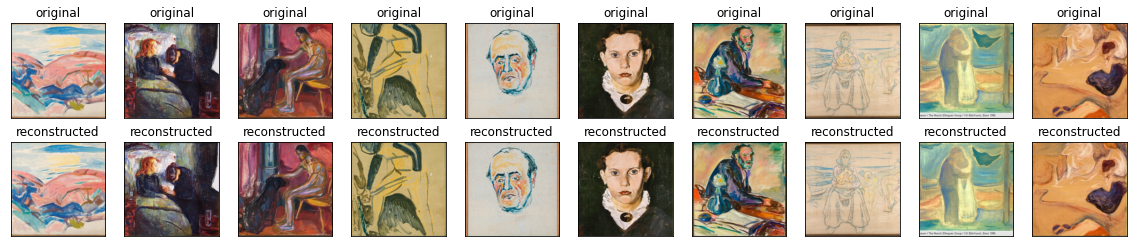

In [14]:
test_img_show(ori_imgs_te_munch, recon_imgs_te_munch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


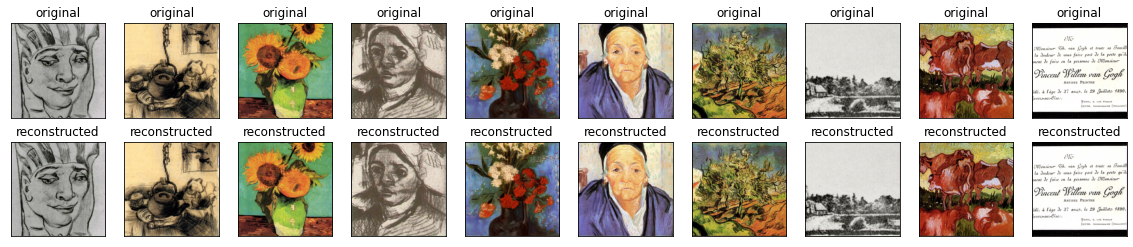

In [15]:
test_img_show(ori_imgs_te_vincent, recon_imgs_te_vincent)

4. Detect anomalies

Calculating whether the reconstruction loss is greater than a fixed threshold, which is the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set

4.1 Plot reconstruction error of training and choose a threshold value that is one standard deviations above the mean.

0
10
20
30
40


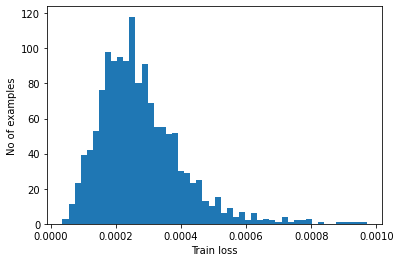

In [29]:
train_loss_ls = []
with torch.no_grad():
    anomaly_detector.eval()
    for i, data in enumerate(train_loader):
        if i%10==0: print(i)
        batch_features = data[0]
        # load it to active device
        batch_features = batch_features.to(device)
        for j in range(len(batch_features)):
            reconstructed = anomaly_detector(batch_features[j].unsqueeze(0))
            train_loss = anomaly_detector_criterion(reconstructed, batch_features[j].unsqueeze(0))
            train_loss_ls.append(train_loss.item())

plt.hist(train_loss_ls, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [30]:
threshold = np.mean(train_loss_ls) + np.std(train_loss_ls)
print("Threshold: ", threshold)

Threshold:  0.00040382378671632515


4.2 Examine the reconstruction error for the normal/anomalous examples in the test sets

0
10


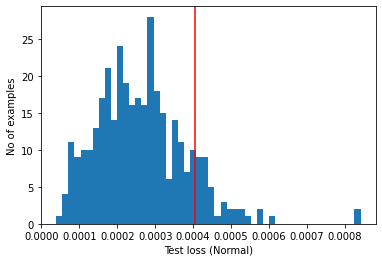

In [32]:
test_loss_munch_ls = []
with torch.no_grad():
    anomaly_detector.eval()
    for i, data in enumerate(test_loader_munch):
        if i%10==0: print(i)
        batch_features = data[0]
        # load it to active device
        batch_features = batch_features.to(device)
        for j in range(len(batch_features)):
            reconstructed = anomaly_detector(batch_features[j].unsqueeze(0))
            test_loss = anomaly_detector_criterion(reconstructed, batch_features[j].unsqueeze(0))
            test_loss_munch_ls.append(test_loss.item())
            
plt.hist(test_loss_munch_ls, bins=50)
plt.axvline(x=threshold, c='red')
plt.xlabel("Test loss (Normal)")
plt.ylabel("No of examples")
plt.show()

0
10


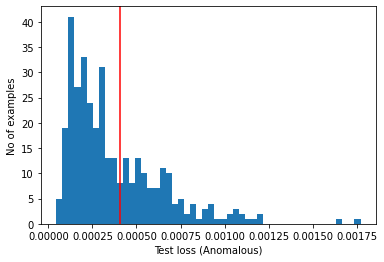

In [33]:
test_loss_vincent_ls = []
with torch.no_grad():
    anomaly_detector.eval()
    for i, data in enumerate(test_loader_vincent):
        if i%10==0: print(i)
        batch_features = data[0]
        # load it to active device
        batch_features = batch_features.to(device)
        for j in range(len(batch_features)):
            reconstructed = anomaly_detector(batch_features[j].unsqueeze(0))
            test_loss = anomaly_detector_criterion(reconstructed, batch_features[j].unsqueeze(0))
            test_loss_vincent_ls.append(test_loss.item())
            
plt.hist(test_loss_vincent_ls, bins=50)
plt.axvline(x=threshold, c='red')
plt.xlabel("Test loss (Anomalous)")
plt.ylabel("No of examples")
plt.show()

4.3 Classify an paintings as an anomaly if the reconstruction error is greater than the threshold.

In [59]:
def predict(model, dataloader, threshold):
  loss_ls = []
  with torch.no_grad():
      model.eval()
      for i, data in enumerate(dataloader):
          if i%10==0: print(i)
          batch_features = data[0]
          # load it to active device
          batch_features = batch_features.to(device)
          for j in range(len(batch_features)):
              reconstructed = anomaly_detector(batch_features[j].unsqueeze(0))
              loss = anomaly_detector_criterion(reconstructed, batch_features[j].unsqueeze(0))
              loss_ls.append(loss.item())
  return np.less(loss_ls, threshold) # Munch label =1(T), Vincent label = 0(F)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

preds_ls_munch = predict(anomaly_detector, test_loader_munch, threshold)
preds_ls_vincent = predict(anomaly_detector, test_loader_vincent, threshold)
preds_ls_comb = np.concatenate((preds_ls_munch,preds_ls_vincent))
label_ls_munch = np.ones(preds_ls_munch.shape)
label_ls_vincent = np.zeros(preds_ls_vincent.shape)
label_ls_comb = np.concatenate((label_ls_munch,label_ls_vincent))

print_stats(preds_ls_munch, label_ls_munch)
print_stats(preds_ls_vincent, label_ls_vincent)
print_stats(preds_ls_comb, label_ls_comb)

0
10
0
10
Accuracy = 0.8828571428571429
Precision = 1.0
Recall = 0.8828571428571429
Accuracy = 0.3457142857142857
Precision = 0.0
Recall = 0.0
Accuracy = 0.6142857142857143
Precision = 0.5743494423791822
Recall = 0.8828571428571429


/Users/jao/opt/miniconda3/envs/d2l/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
